In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import plot_tree

In [50]:
def data_results(testing_classes, testing_inputs, alg_class):
    cm_display = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(testing_classes, alg_class.predict(testing_inputs))
    )

    cm_display.plot()
    plt.xticks([0, 1], ["No", "Yes"])
    plt.yticks([0, 1], ["No", "Yes"])
    plt.xlabel('Predicted Entry')
    plt.ylabel('Actual Entry')
    plt.show()

    print(classification_report(testing_classes, alg_class.predict(testing_inputs)))

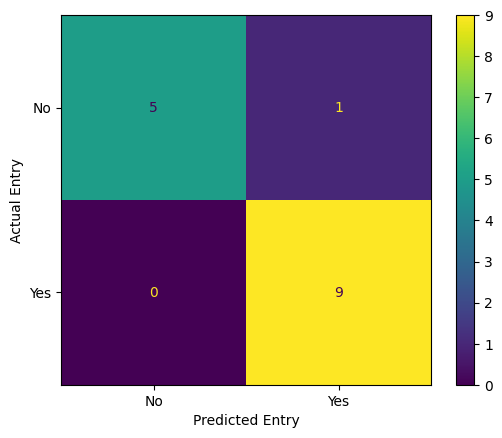

              precision    recall  f1-score   support

           N       1.00      0.83      0.91         6
           Y       0.90      1.00      0.95         9

    accuracy                           0.93        15
   macro avg       0.95      0.92      0.93        15
weighted avg       0.94      0.93      0.93        15



[Text(0.7125, 0.9615384615384616, 'Cumulative Win Rate <= 0.528\ngini = 0.493\nsamples = 84\nvalue = [37, 47]'),
 Text(0.575, 0.8846153846153846, 'homeW <= 12.5\ngini = 0.489\nsamples = 54\nvalue = [31, 23]'),
 Text(0.45, 0.8076923076923077, 'Cumulative Win Rate <= 0.449\ngini = 0.458\nsamples = 45\nvalue = [29.0, 16.0]'),
 Text(0.35, 0.7307692307692307, 'Cumulative Win Rate <= 0.423\ngini = 0.499\nsamples = 29\nvalue = [15.0, 14.0]'),
 Text(0.3, 0.6538461538461539, 'Defensive Score <= 0.02\ngini = 0.469\nsamples = 24\nvalue = [15, 9]'),
 Text(0.2, 0.5769230769230769, 'Defensive Score <= 0.011\ngini = 0.5\nsamples = 16\nvalue = [8, 8]'),
 Text(0.15, 0.5, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.25, 0.5, 'Cumulative Win Rate <= 0.211\ngini = 0.49\nsamples = 14\nvalue = [6, 8]'),
 Text(0.2, 0.4230769230769231, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.3, 0.4230769230769231, 'homeW <= 10.5\ngini = 0.496\nsamples = 11\nvalue = [6, 5]'),
 Text(0.25, 0.34615384615384615,

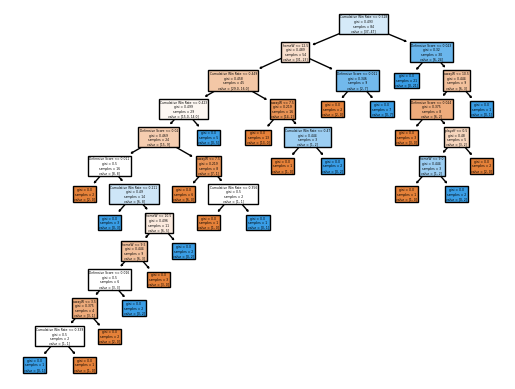

In [51]:
df_teams = pd.read_csv('dataset/processed/teams_test.csv')
df_teams = df_teams.sort_values(by=['franchID', 'year'])
df_teams['playoffNextYear'] = df_teams['playoff'].shift(-1)
df_teams.loc[df_teams['franchID'] != df_teams['franchID'].shift(-1), 'playoffNextYear'] = None
df_teams.dropna(subset=['playoffNextYear'], inplace=True)

label_encoder = LabelEncoder()
df_teams['playoff'] = label_encoder.fit_transform(df_teams['playoff'])

features = ['homeW', 'awayW', 'playoff', 'Attacking Score', 'Defensive Score', 'Cumulative Win Rate'] # attend?

df_teams_train = df_teams[df_teams['year'] <= 5]
df_teams_test = df_teams[df_teams['year'].isin([6])]

# df_teams_train = df_teams[df_teams['year'] <= 5]
# df_teams_test = df_teams[df_teams['year'].isin([6])]

training_inputs = df_teams_train[features]
training_classes = df_teams_train['playoffNextYear']
testing_inputs = df_teams_test[features]
testing_classes = df_teams_test['playoffNextYear']

dt_class = DecisionTreeClassifier(random_state=42)
dt_class.fit(training_inputs, training_classes)
# dt_class.predict(testing_inputs)

dt_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, dt_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, dt_class)

plot_tree(dt_class, feature_names=features, filled=True)

[[0.28 0.72]
 [0.25 0.75]
 [0.25 0.75]
 [0.86 0.14]
 [0.91 0.09]
 [0.21 0.79]
 [0.83 0.17]
 [0.16 0.84]
 [0.73 0.27]
 [0.82 0.18]
 [0.31 0.69]
 [0.25 0.75]
 [0.24 0.76]
 [0.76 0.24]
 [0.91 0.09]
 [0.75 0.25]
 [0.29 0.71]
 [0.14 0.86]
 [0.07 0.93]
 [0.03 0.97]
 [0.07 0.93]
 [0.24 0.76]
 [0.86 0.14]
 [0.11 0.89]
 [0.74 0.26]
 [0.25 0.75]
 [0.88 0.12]
 [0.88 0.12]
 [0.27 0.73]
 [0.04 0.96]
 [0.03 0.97]
 [0.05 0.95]
 [0.04 0.96]
 [0.03 0.97]
 [0.02 0.98]
 [0.06 0.94]
 [0.31 0.69]
 [0.76 0.24]
 [0.83 0.17]
 [0.93 0.07]
 [0.83 0.17]
 [0.3  0.7 ]
 [0.14 0.86]
 [0.61 0.39]
 [0.17 0.83]
 [0.04 0.96]
 [0.69 0.31]
 [0.11 0.89]
 [0.01 0.99]
 [0.15 0.85]
 [0.62 0.38]
 [0.73 0.27]
 [0.9  0.1 ]
 [0.95 0.05]
 [0.82 0.18]
 [0.82 0.18]
 [0.95 0.05]
 [0.75 0.25]
 [0.08 0.92]
 [0.24 0.76]
 [0.79 0.21]
 [0.21 0.79]
 [0.   1.  ]
 [0.   1.  ]
 [0.03 0.97]
 [0.13 0.87]
 [0.22 0.78]
 [0.06 0.94]
 [0.87 0.13]
 [0.86 0.14]
 [0.79 0.21]
 [0.97 0.03]
 [0.97 0.03]
 [0.87 0.13]
 [0.13 0.87]
 [0.83 0.17]
 [0.24 0.76]

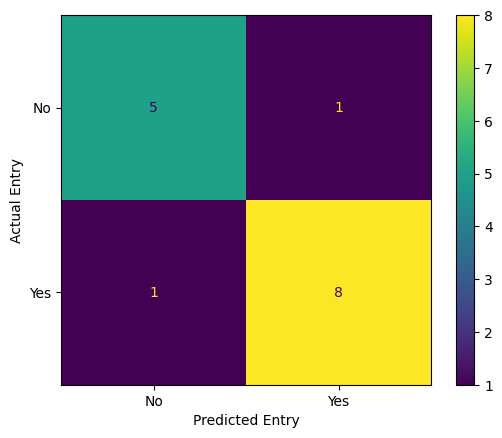

              precision    recall  f1-score   support

           N       0.83      0.83      0.83         6
           Y       0.89      0.89      0.89         9

    accuracy                           0.87        15
   macro avg       0.86      0.86      0.86        15
weighted avg       0.87      0.87      0.87        15



In [52]:
rf_class = RandomForestClassifier(n_estimators=100)
rf_class.fit(training_inputs, training_classes)

print(rf_class.predict_proba(training_inputs))

rf_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, rf_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, rf_class)

In [53]:
nb_class = GaussianNB()
nb_class.fit(training_inputs, training_classes)

nb_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, nb_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, nb_class)

ValueError: Input X contains NaN.
GaussianNB does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

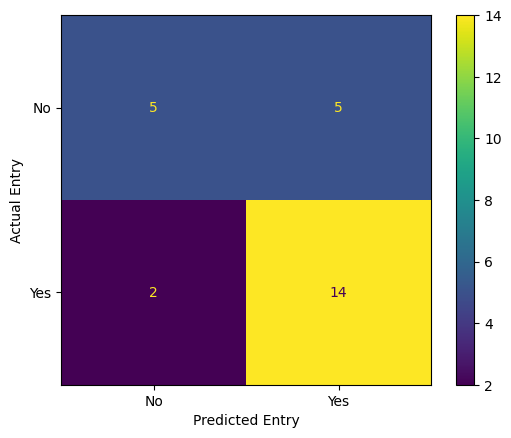

              precision    recall  f1-score   support

           N       0.71      0.50      0.59        10
           Y       0.74      0.88      0.80        16

    accuracy                           0.73        26
   macro avg       0.73      0.69      0.69        26
weighted avg       0.73      0.73      0.72        26



In [223]:
svm_class = SVC(kernel='rbf')
svm_class.fit(training_inputs, training_classes)

svm_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, svm_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, svm_class)

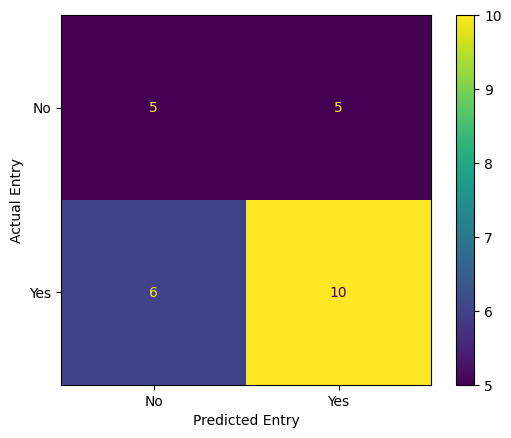

              precision    recall  f1-score   support

           N       0.45      0.50      0.48        10
           Y       0.67      0.62      0.65        16

    accuracy                           0.58        26
   macro avg       0.56      0.56      0.56        26
weighted avg       0.59      0.58      0.58        26



In [224]:
knn_class = KNeighborsClassifier(n_neighbors=5)
knn_class.fit(training_inputs, training_classes)

knn_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, knn_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, knn_class)

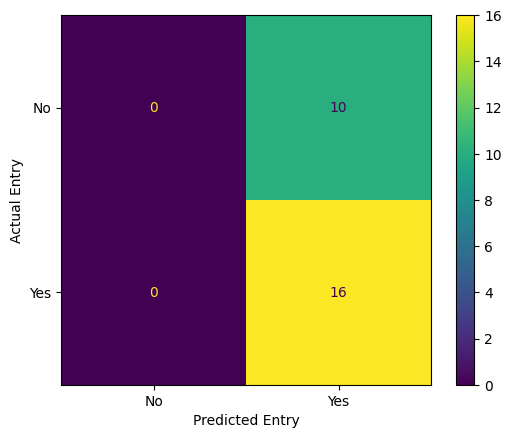

              precision    recall  f1-score   support

           N       0.00      0.00      0.00        10
           Y       0.62      1.00      0.76        16

    accuracy                           0.62        26
   macro avg       0.31      0.50      0.38        26
weighted avg       0.38      0.62      0.47        26



c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [225]:
ann_class = MLPClassifier(random_state=42, max_iter=300)
ann_class.fit(training_inputs, training_classes)

ann_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, ann_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, ann_class)

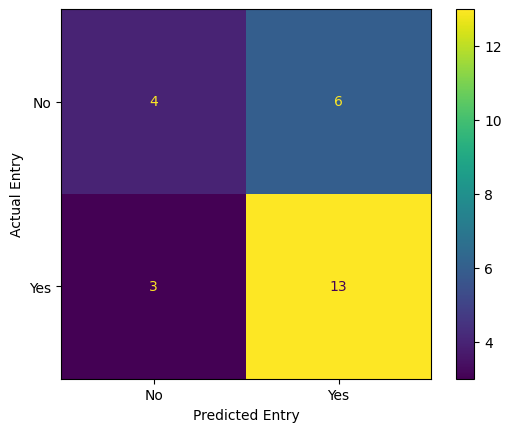

              precision    recall  f1-score   support

           N       0.57      0.40      0.47        10
           Y       0.68      0.81      0.74        16

    accuracy                           0.65        26
   macro avg       0.63      0.61      0.61        26
weighted avg       0.64      0.65      0.64        26



In [226]:
ab_class = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=42)
ab_class.fit(training_inputs, training_classes)

ab_class.score(testing_inputs, testing_classes)

accuracy_score(testing_classes, ab_class.predict(testing_inputs))

data_results(testing_classes, testing_inputs, ab_class)

In [227]:
df_teams.head(10)

,year,tmID,franchID,confID,rank,playoff,firstRound,semis,finals,name,...,homeL,awayW,awayL,confW,confL,min,Attacking Score,Defensive Score,Awards Count,playoffNextYear
0,9,ATL,ATL,EA,7,0,NaN,NaN,NaN,Atlanta Dream,...,16,3,14,2,18,6825,0.330981,0.024429,0.000000,Y
2,1,CHA,CHA,EA,8,0,NaN,NaN,NaN,Charlotte Sting,...,11,3,13,5,16,6475,0.352588,0.011721,0.000000,Y
3,2,CHA,CHA,EA,4,1,W,W,L,Charlotte Sting,...,5,7,9,15,6,6500,0.324724,0.014848,0.000000,Y
4,3,CHA,CHA,EA,2,1,L,NaN,NaN,Charlotte Sting,...,5,7,9,12,9,6450,0.273956,0.010089,0.000000,Y
5,4,CHA,CHA,EA,2,1,L,NaN,NaN,Charlotte Sting,...,4,5,12,12,12,6850,0.379441,0.020752,0.000000,N
6,5,CHA,CHA,EA,5,0,NaN,NaN,NaN,Charlotte Sting,...,7,6,11,8,12,6900,0.332921,0.020340,0.000000,N
7,6,CHA,CHA,EA,6,0,NaN,NaN,NaN,Charlotte Sting,...,12,1,16,4,16,6945,0.285336,0.013298,0.000000,N
9,7,CHI,CHI,EA,7,0,NaN,NaN,NaN,Chicago Sky,...,14,2,15,4,16,6800,0.252544,0.019094,0.000000,N
10,8,CHI,CHI,EA,6,0,NaN,NaN,NaN,Chicago Sky,...,11,8,9,6,14,6972,0.290606,0.013964,0.071429,N
11,9,CHI,CHI,EA,5,0,NaN,NaN,NaN,Chicago Sky,...,9,4,13,10,10,6875,0.253876,0.019557,0.000000,N
